<a href="https://colab.research.google.com/github/sttesta3/7506R-1C2024-GRUPO08/blob/santiago/Clasificaci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Seteo inicial del notebook y carga de datos


In [1]:
# General libs
import pandas as pd
import numpy as np

import geopandas as gpd
from shapely.geometry import Point

#Visualizaciones
import seaborn as sns
import matplotlib.pyplot as plt

#Modelos
from sklearn.cluster import KMeans
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# KFold cross validation
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix, classification_report , f1_score

from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.model_selection import train_test_split

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

!pip install 'dtreeviz'
import dtreeviz


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 1.7 MB/s eta 0:00:00


In [2]:
# Ruta donde van a estar todos los datasets
ruta = "https://raw.githubusercontent.com/sttesta3/7506R-1C2024-GRUPO08/fede/datasets/"
ds = pd.read_csv(ruta + "ds_filtrado.csv")
ds.drop(columns=["start_date"],inplace=True)
ds.info()

# No se elimina data. Arbol de decision funciona con data no numerica. Se separa antes de crear pxm2
# ds_train, ds_test = train_test_split(pd.get_dummies(ds.drop(columns=["place_l3"]),columns=["property_type"]), test_size=0.2 , random_state=2)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52366 entries, 0 to 52365
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   latitud                   52366 non-null  float64
 1   longitud                  52366 non-null  float64
 2   place_l3                  52366 non-null  object 
 3   property_type             52366 non-null  object 
 4   property_rooms            52366 non-null  int64  
 5   property_bedrooms         52366 non-null  int64  
 6   property_surface_total    52366 non-null  float64
 7   property_surface_covered  52366 non-null  float64
 8   property_price            52366 non-null  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 3.6+ MB




### Analisis PXM2

#### Creacion de nueva columna Precio/metro cuadrado (pxm2)

In [3]:
ds['pxm2'] = ds.apply(lambda row: row.property_price/row.property_surface_total, axis=1)
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52366 entries, 0 to 52365
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   latitud                   52366 non-null  float64
 1   longitud                  52366 non-null  float64
 2   place_l3                  52366 non-null  object 
 3   property_type             52366 non-null  object 
 4   property_rooms            52366 non-null  int64  
 5   property_bedrooms         52366 non-null  int64  
 6   property_surface_total    52366 non-null  float64
 7   property_surface_covered  52366 non-null  float64
 8   property_price            52366 non-null  float64
 9   pxm2                      52366 non-null  float64
dtypes: float64(6), int64(2), object(2)
memory usage: 4.0+ MB


#### Analisis estadistico inicial
#### Vale mencionar que es una variable que esperamos que presente una tendencia normal, ya que en los distintos grupos de propiedades encontraremos que localmente se respetan las condiciones de independencia e igualdad de distribución.
#### En conclusión, esperamos que en cada grupo de propiedades se comporten como una normal ( o que la cantidad de observaciones sea la suficiente como para que el error sea despreciable ) , y el total de la distribución será la suma de las mismas ( otra distribución normal ).

In [ ]:
print(ds.pxm2.mean())
print(ds.pxm2.std())


2289.833722342549
688.0194009535691


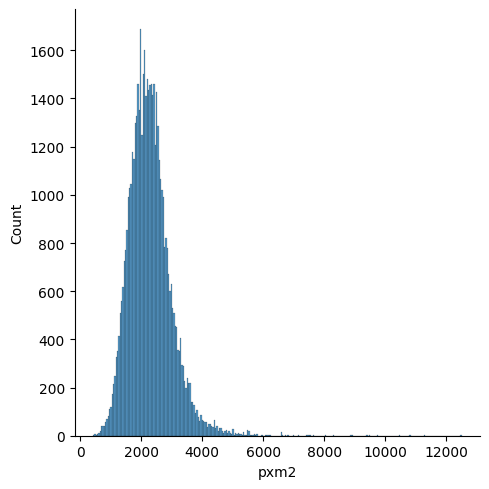

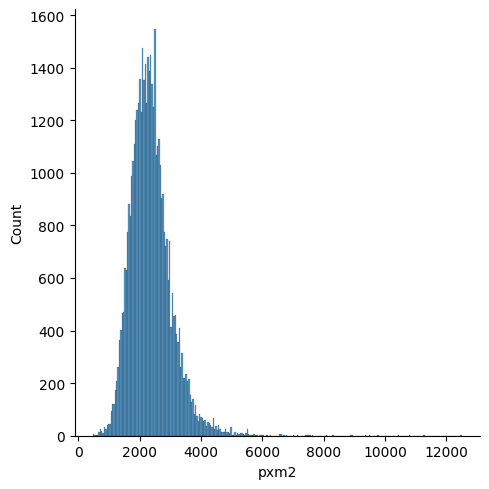

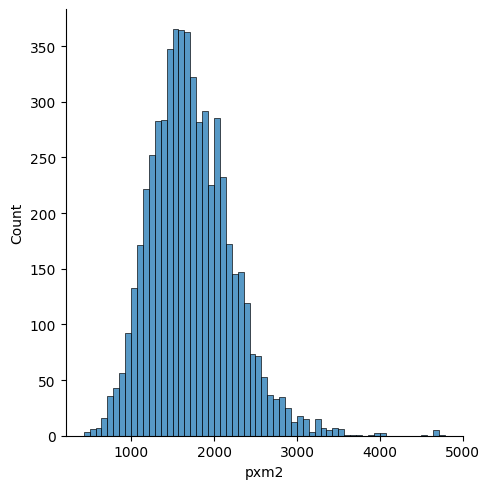

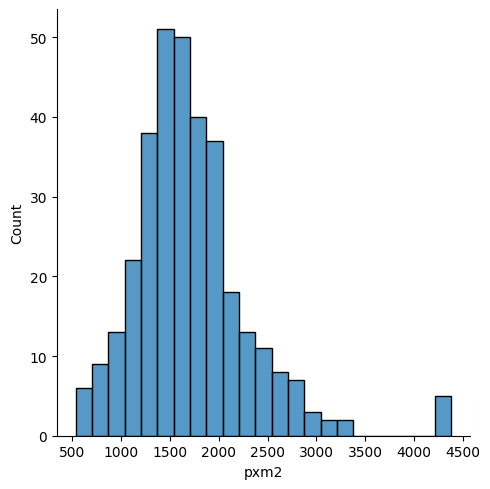

In [ ]:
ds.describe()
sns.displot(ds,x="pxm2",kind="hist")
for i in ds.property_type.unique():
  sns.displot(ds.loc[ds['property_type'] == i ],x="pxm2",kind="hist")

##### Algo importante de mencionar, es que el gráfico total y el de departamentos son muy similares, mientras que no lo son tanto con los otros dos tipos de propiedades. Esto se debe principalmente a la cantidad de elementos de cada tipo en el dataset, el cual esta compuesto en un 88% por departamentos, 11% PH y 1% de casas.
#### Tambien vale mencionar que nuestra hipotesis de normalidad se ve confirmada, ya que la media total resulta el promedio de las medias de las distribuciones,


In [ ]:
# Comprobación de normalidad en datos
estadisticas = {}
estadisticas["Total"] = [ds.property_type.count(),ds.pxm2.mean(),ds.pxm2.std()]

for i in ds.property_type.unique():
  estadisticas[i] = [ds.loc[ds["property_type"] == i ].property_type.count(),ds.loc[ds["property_type"] == i ].pxm2.mean(),ds.loc[ds["property_type"] == i ].pxm2.std()]

for i in estadisticas.keys():
  print("{} | Cant: {} | mean: {} | std {}".format(i,estadisticas[i][0],round(estadisticas[i][1],3),round(estadisticas[i][2],3)))


def calc_total(estadisticas):
  promedio_total = 0
  std_total = 0

  for i in estadisticas.keys():
    if ( i != "Total"):
      promedio_total += estadisticas[i][0]*estadisticas[i][1]
      std_total += estadisticas[i][0]*(estadisticas[i][2]**2)

  return [promedio_total/estadisticas["Total"][0],np.sqrt(std_total/estadisticas["Total"][0])]

print(calc_total(estadisticas))


Total | Cant: 52366 | mean: 2289.834 | std 688.019
Departamento | Cant: 46336 | mean: 2363.713 | std 674.421
PH | Cant: 5695 | mean: 1722.662 | std 495.436
Casa | Cant: 335 | mean: 1713.052 | std 596.56
[2289.8337223425488, 656.8406317034095]


#### División en grupos

In [4]:
# Creación de los límites
division_equitativa = np.percentile( ds.pxm2, [33, 66])
division_percentil = np.percentile( ds.pxm2, [25, 75])
division_gaussiana = np.percentile( ds.pxm2, [15.87, 84.13]) # Dentro de un sigma

# Separación de los datasets
equitativas = []
equitativas.append( ds[ds.pxm2 < division_equitativa[0]])
equitativas.append( ds[ (ds.pxm2 < division_equitativa[1]) & (ds.pxm2 > division_equitativa[0]) ])
equitativas.append( ds[ ds.pxm2 > division_equitativa[1] ])

#equitativas.append( ds[ds['pxm2'] < ds['pxm2'].quantile(0.25)]  )
#equitativas.append( ds.pxm2.quantile([.25,.75]) )
#equitativas.append( ds.pxm2.quantile([.75,1]) )


percentil = []
percentil.append( ds[ds.pxm2 < division_percentil[0]])
percentil.append( ds[ (ds.pxm2 < division_percentil[1]) & (ds.pxm2 > division_percentil[0]) ])
percentil.append( ds[ ds.pxm2 > division_percentil[1] ])

gauss = []
gauss.append( ds[ds.pxm2 < division_gaussiana[0]])
gauss.append( ds[ (ds.pxm2 < division_gaussiana[1]) & (ds.pxm2 > division_gaussiana[0]) ])
gauss.append( ds[ ds.pxm2 > division_gaussiana[1] ])

In [ ]:
for i in equitativas:
  print(i.pxm2.count())
print("------------------------------")
for i in percentil:
  print(i.pxm2.count())
print("------------------------------")
for i in gauss:
  print(i.pxm2.count())

17271
17234
17798
------------------------------
13079
26159
13088
------------------------------
8308
35725
8278


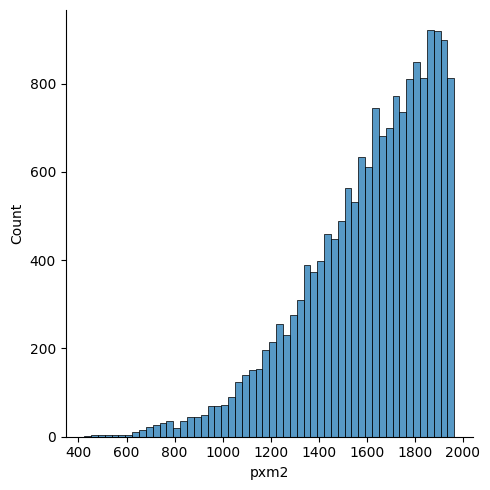

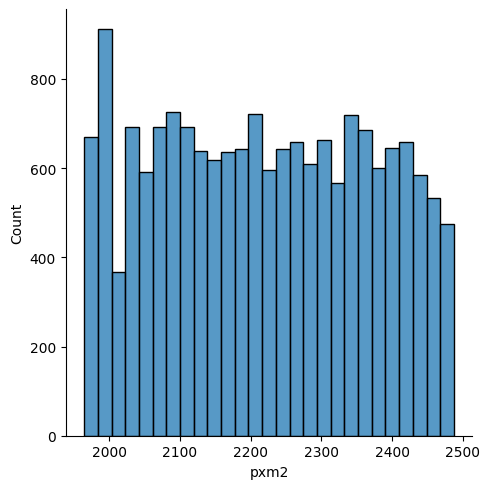

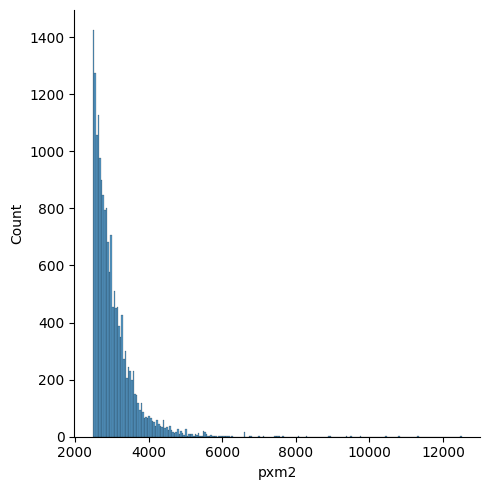

In [ ]:
for i in equitativas:
  sns.displot(i,x="pxm2",kind="hist")

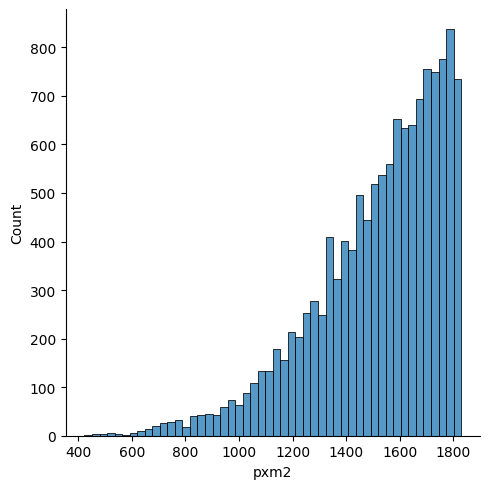

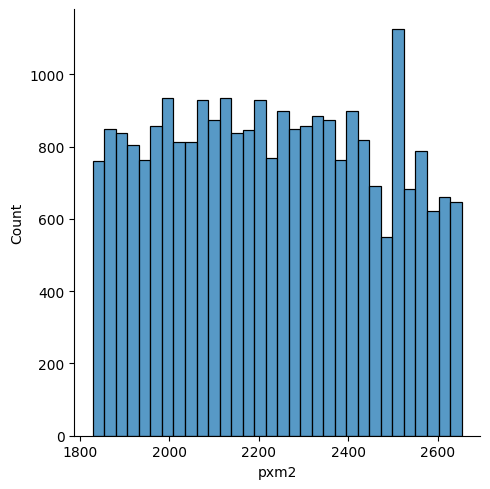

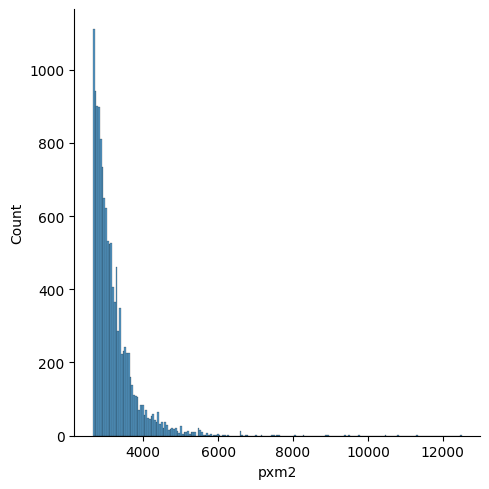

In [ ]:
for i in percentil:
  sns.displot(i,x="pxm2",kind="hist")

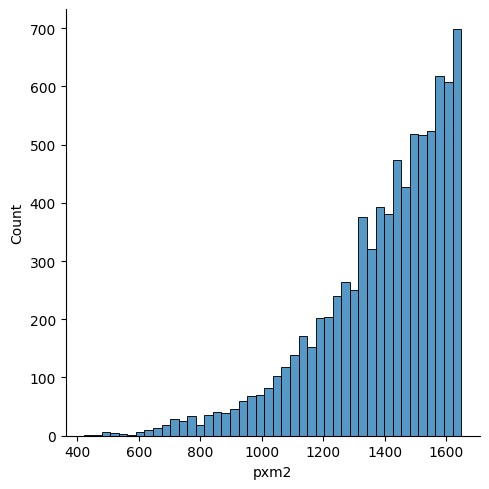

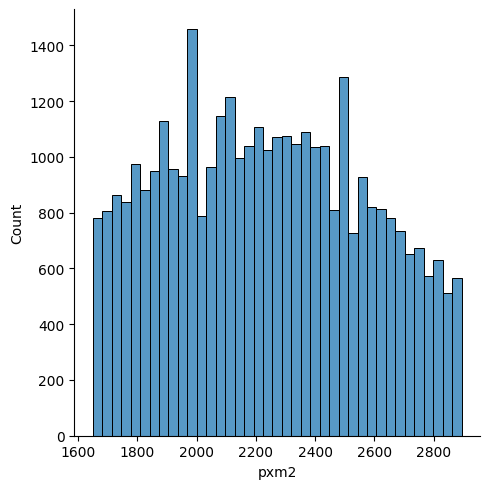

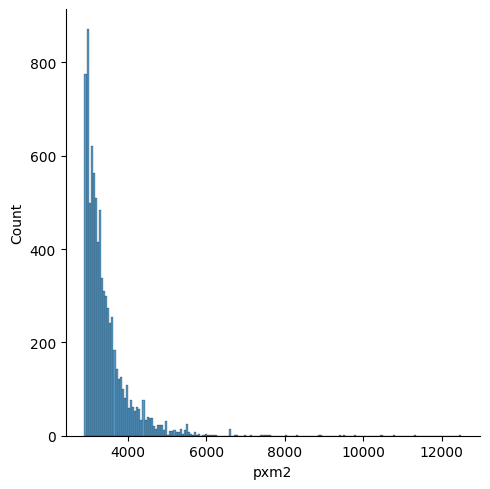

In [ ]:
for i in gauss:
  sns.displot(i,x="pxm2",kind="hist")

##### La alternativa elegida es percentiles. El motivo es que creemos que es la opción más representativa para la calificación en precio bajo-medio-alto, ya que siendo una distribución normal lo más acorde es separar normal de anormal en desviaciones estandar, lo cual nos lleva a dividir el dataset en 0 a 16%, 16% a 84% y 84% al 100%. Entonces, la división más cercana es la de percentiles ( 0 a 25%, 25% a 75% y 75% a 100% ).
##### Además descartamos la división de tipo de precio tambien por departamento, PH y Casa ya que no resulta muy significativo por la composición del dataset.

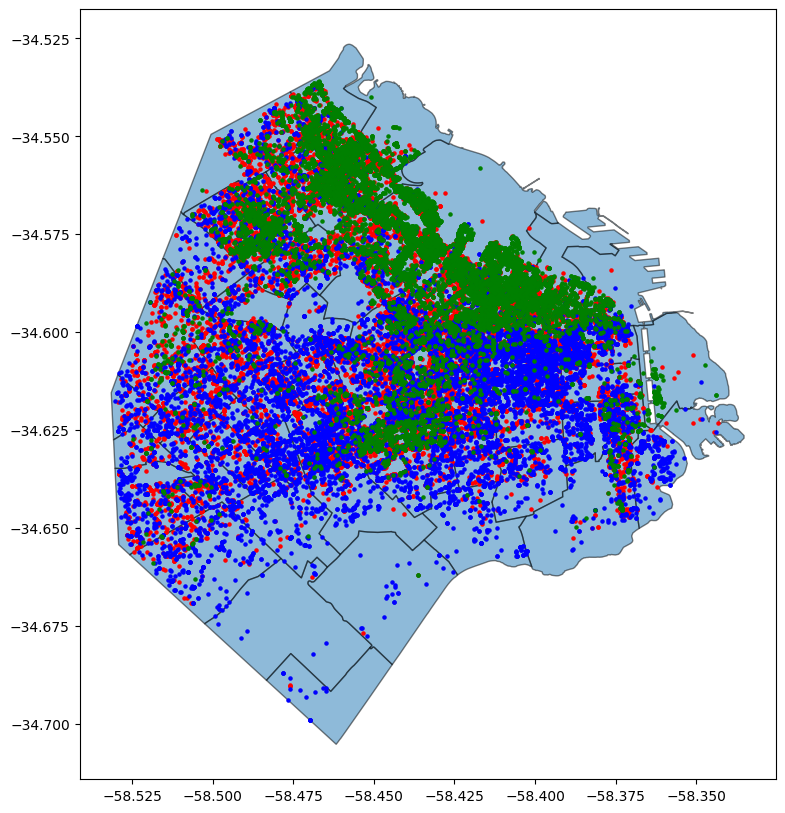

In [ ]:
# Cargar el archivo GeoJSON de los barrios de CABA
barrios_caba = gpd.read_file(ruta + "barrios_caba.geojson")

# Crear un dataset con latitud, longitud y pxm2, y entrenar modelo con dicho Ds

# Convertir latitud y longitud en puntos geométricos
geometrias = []
for i in percentil:
  geometrias.append([Point(xy) for xy in zip(i["longitud"], i["latitud"]) ])

crs = {"init": "epsg:4326"}  # Sistema de coordenadas WGS84

# Crear un GeoDataFrame a partir del DataFrame limpio y los puntos geométricos
gdfs_propiedades = []
for i in range(0,len(percentil)):
  gdfs_propiedades.append(
      gpd.GeoDataFrame(
        percentil[i],
        crs=crs,
        geometry=geometrias[i]
      )
  )


# Paso 2: Plotear el resultado sobre un mapa
import matplotlib.pyplot as plt

# Plotear los barrios de CABA
barrios_caba.plot(
    alpha=0.5,
    edgecolor="k",
    figsize=(10, 10)
    )

def selector_color(i=int):
  if i == 0:
    return "blue" # Aka precio bajo
  elif i == 1:
    return "red" # Aka precio medio
  elif i == 2:
    return "green" # Aka precio alto


# Plotear los puntos filtrados
for i in (1,0,2): # Orden 1-0-2 para que imprima en el mismo orden que el mapa del punto de agrupamiento
  gdfs_propiedades[i].plot(
    ax=plt.gca(),
    marker="o",
    color=selector_color(i),
    markersize=5,
    )


# Muestro toda la grafica.
plt.show()

###### El resultado tiene, por lo menos cualitativamente, una gran similitud con el mapa del resultado por kmeans.
###### La mayor coincidencia con la división por kmeans la encontramos en los grupos de precio alto y bajo, ya que en ambos ejemplos en la zona costera de Capital ( Belgrano, Nuñez, Palermo, Recoleta, Retiro) hay una mayoría de propiedades del grupo verde, donde los datos parecen agruparse principalmente por precio. Luego, en toda la zona en los límites con Gral y el riachuelo el grupo verde reduce sus apariciones y toman caracter principal los otros dos.

#### Crear columna tipo precio

In [5]:
def definir_precio(row):
  if row.pxm2 < division_percentil[0]:
    return 'bajo'
  elif row.pxm2 < division_percentil[1]:
    return 'medio'
  else:
    return 'alto'

ds['tipo_precio'] = ds.apply(lambda row: definir_precio(row), axis=1)


### Arbol de Decisión

##### El problema de clasificación a resolver busca:
0. Maximizar la cantidad de verdaderos positivos ( premisa base de cualquier sistema de clasificación )  
1. Maximizar la cantidad de aciertos dentro de los casos positivos ( Recall ).
2. Maximizar la cantidad de aciertos dentro de los casos clasificados como positivos ( Precision ). O minimizar los falsos positivos  

Por lo tanto, elegiremos la metrica F1-Score debido a que en el problema debemos tener en cuenta ambas metricas para la clasificación en igual cantidad.
##### Nota:  Tambien podrìamos haber elegido accuracy, pero la diferencia es que esta métrica mide el desempeño global del modelo ( cantidad de aciertos / cantidad de elementos en el dataset ), lo cual involucra a los verdaderos negativos que no consideramos de gran relevancia en la clasificación ( preferimos que se equivoque y clasifique mal algunos negativos a que deje pasar positivos ).

In [6]:
# Preparando la data
ds_id3_2 = pd.get_dummies(ds.drop(columns=["property_price","pxm2"]),columns=["property_type","place_l3","tipo_precio"])

target=['tipo_precio_alto','tipo_precio_medio','tipo_precio_bajo']
features= ds_id3_2.drop(columns=target).columns.values

for i in target:
  ds_id3_2[i] = ds_id3_2[i].map({True:0,False:1},na_action=None)


In [48]:
# Entrenamiento de los tres arboles y recolección de métricas/Datos utiles
# Disclaimer: Es un proceso lento, encarecidamente le recomendamos ir por un café. Para cuando vuelva estará terminado :)

mejores_arboles = []
metricsCV_arboles = []

X_test_total = []
Y_test_total = []

for i in range(0,3):                  # Iteramos por los tipos de precio entrenando con kfold cross validation
  print("ARBOL PARA CLASIFICAR",i)    # Prints para ver estado del computo
  arboles_tipo = []
  metricsCV_tipo = []
  X_test_tmp = []
  Y_test_tmp = []
  for ii in range(3,21):              # Probamos de 3 a 20 folds
    print("FOLDS",ii)                 # Prints para ver estado del computo
    arbolcv = DecisionTreeClassifier()

    X_train2, X_test2, Y_train2, Y_test2 = train_test_split(ds_id3_2[features].values,
                                                    ds_id3_2[target[i]].values,
                                                    test_size=0.2,    #20% 0 conjunto de test
                                                    stratify=ds_id3_2[target[i]].values) #estratificado para mantener proporcion

    X_test_tmp.append(X_test2)        # Agregamos test para despues
    Y_test_tmp.append(Y_test2)

    resultados = cross_validate(arbolcv,X_train2, Y_train2, cv=StratifiedKFold(n_splits=ii),scoring=make_scorer(f1_score),return_estimator=True)
    metricsCV=resultados['test_score']
    arboles_tipo.append(resultados['estimator'][np.where(metricsCV==max(metricsCV))[0][0]] )  # Elegimos el mejor de los arboles
    metricsCV_tipo.append(metricsCV)

  mejores_arboles.append(arboles_tipo)
  metricsCV_arboles.append(metricsCV_tipo)

  X_test_total.append(X_test_tmp)
  Y_test_total.append(Y_test_tmp)


ARBOL PARA CLASIFICAR 0
FOLDS 3
FOLDS 4
FOLDS 5
FOLDS 6
FOLDS 7
FOLDS 8
FOLDS 9
FOLDS 10
FOLDS 11
FOLDS 12
FOLDS 13
FOLDS 14
FOLDS 15
FOLDS 16
FOLDS 17
FOLDS 18
FOLDS 19
FOLDS 20
ARBOL PARA CLASIFICAR 1
FOLDS 3
FOLDS 4
FOLDS 5
FOLDS 6
FOLDS 7
FOLDS 8
FOLDS 9
FOLDS 10
FOLDS 11
FOLDS 12
FOLDS 13
FOLDS 14
FOLDS 15
FOLDS 16
FOLDS 17
FOLDS 18
FOLDS 19
FOLDS 20
ARBOL PARA CLASIFICAR 2
FOLDS 3
FOLDS 4
FOLDS 5
FOLDS 6
FOLDS 7
FOLDS 8
FOLDS 9
FOLDS 10
FOLDS 11
FOLDS 12
FOLDS 13
FOLDS 14
FOLDS 15
FOLDS 16
FOLDS 17
FOLDS 18
FOLDS 19
FOLDS 20


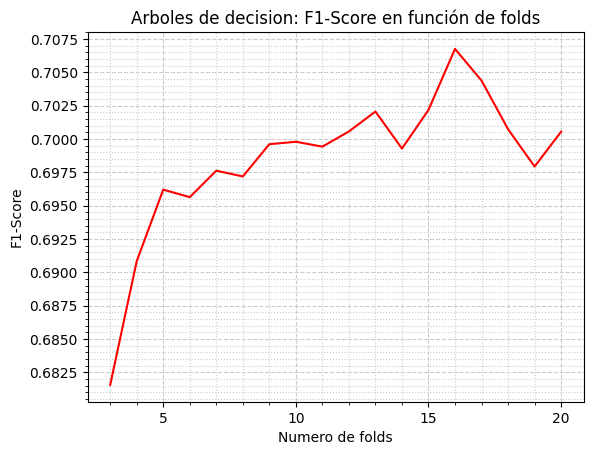

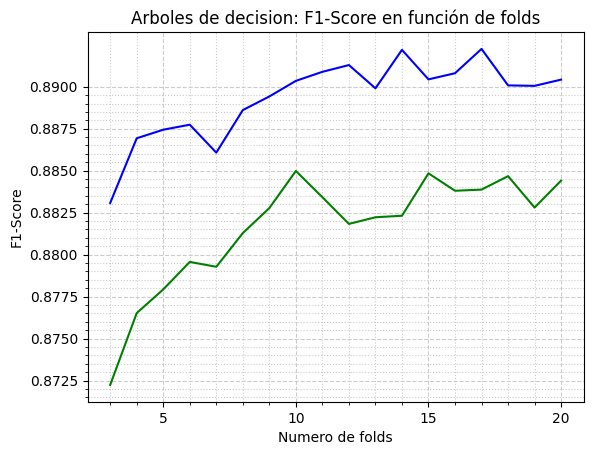

In [51]:
# Graficos de F1-Score en función de Folds
def promedio(lista):
  return sum(lista)/len(lista)

def calcular_promedios(lista):
  resultado = []
  for i in range(len(lista)):
    resultado.append(promedio(lista[i]))
  return resultado

tipo_precio_alto = calcular_promedios(metricsCV_arboles[0])
tipo_precio_medio = calcular_promedios(metricsCV_arboles[1])
tipo_precio_bajo = calcular_promedios(metricsCV_arboles[2])

fig = plt.figure()
ax = fig.add_subplot()
x_major_ticks = np.arange(0, 22, 5)
x_minor_ticks = np.arange(0, 22, 1)
y_major_ticks = np.arange(0.6, 0.75, 0.0025)
y_minor_ticks = np.arange(0.6, 0.75, 0.0005)

ax.set_xticks(x_major_ticks)
ax.set_xticks(x_minor_ticks, minor=True)
ax.set_yticks(y_major_ticks)
ax.set_yticks(y_minor_ticks, minor=True)

ax.grid(which='minor', color='#CCCCCC', linestyle=':')
ax.grid(which='major', color='#CCCCCC', linestyle='--')

ax.set_xlabel("Numero de folds")
ax.set_ylabel("F1-Score")
ax.set_title("Arboles de decision: F1-Score en función de folds")

plt.plot(range(3,21), tipo_precio_medio, label="F1-Score tipo precio medio",color="red")

plt.show()

fig = plt.figure()
ax = fig.add_subplot()
x_major_ticks = np.arange(0, 22, 5)
x_minor_ticks = np.arange(0, 22, 1)
y_major_ticks = np.arange(0.85, 0.89, 0.0025)
y_minor_ticks = np.arange(0.85, 0.89, 0.0005)

ax.set_xticks(x_major_ticks)
ax.set_xticks(x_minor_ticks, minor=True)
ax.set_yticks(y_major_ticks)
ax.set_yticks(y_minor_ticks, minor=True)

ax.grid(which='minor', color='#CCCCCC', linestyle=':')
ax.grid(which='major', color='#CCCCCC', linestyle='--')

ax.set_xlabel("Numero de folds")
ax.set_ylabel("F1-Score")
ax.set_title("Arboles de decision: F1-Score en función de folds")

plt.plot(range(3,21), tipo_precio_alto, label="F1-Score tipo precio alto",color="green")
# plt.plot(range(3,21), tipo_precio_medio, label="F1-Score tipo precio medio",color="red")
plt.plot(range(3,21), tipo_precio_bajo, label="F1-Score tipo precio bajo",color="blue")

plt.show()


# Referencia utilizada para el gráfico https://stackoverflow.com/questions/24943991/change-grid-interval-and-specify-tick-labels

##### Encontramos que el punto de concavidad esta en los 7 folds. Por lo que utilizaremos dicho numero como cantidad de folds para cross_validation
Nota: Se plotean en gráficos diferentes ya que por la diferencia en la cantidad de muestras entre el grupo de precio medio y de precio alto y bajo el score para las propiedades medias es menor debido a que tiene un menor grado de overfit

In [65]:
CANT_FOLDS_ELEGIDAS = 7
CANT_FOLDS_MINIMA = 3
# Evaluación contra test
for i in range(0,3):
  y_pred = mejores_arboles[i][CANT_FOLDS_ELEGIDAS-CANT_FOLDS_MINIMA].predict(X_test_total[i][CANT_FOLDS_ELEGIDAS-CANT_FOLDS_MINIMA])
  y_test = Y_test_total[i][CANT_FOLDS_ELEGIDAS-CANT_FOLDS_MINIMA]
  print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.63      0.67      0.65      2620
           1       0.89      0.87      0.88      7854

    accuracy                           0.82     10474
   macro avg       0.76      0.77      0.76     10474
weighted avg       0.82      0.82      0.82     10474

              precision    recall  f1-score   support

           0       0.70      0.71      0.71      5238
           1       0.71      0.70      0.70      5236

    accuracy                           0.71     10474
   macro avg       0.71      0.71      0.71     10474
weighted avg       0.71      0.71      0.71     10474

              precision    recall  f1-score   support

           0       0.67      0.68      0.68      2616
           1       0.89      0.89      0.89      7858

    accuracy                           0.84     10474
   macro avg       0.78      0.79      0.78     10474
weighted avg       0.84      0.84      0.84     10474



Text(50.722222222222214, 0.5, 'Verdadero')

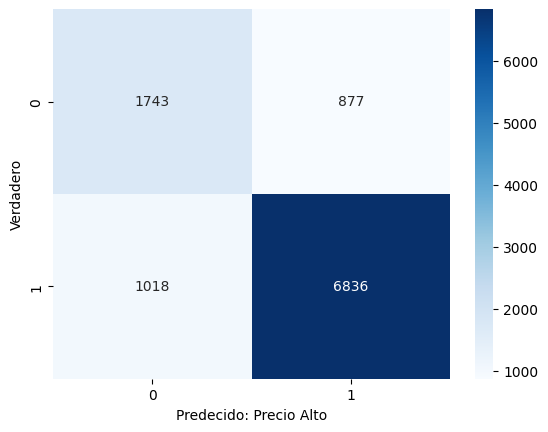

In [66]:
mejor_performance_alto =  mejores_arboles[0][CANT_FOLDS_ELEGIDAS-CANT_FOLDS_MINIMA]
mejor_performance_medio =  mejores_arboles[1][CANT_FOLDS_ELEGIDAS-CANT_FOLDS_MINIMA]
mejor_performance_bajo =  mejores_arboles[2][CANT_FOLDS_ELEGIDAS-CANT_FOLDS_MINIMA]

y_pred_alto= mejor_performance_alto.predict(X_test_total[0][CANT_FOLDS_ELEGIDAS-CANT_FOLDS_MINIMA])
y_pred_medio= mejor_performance_alto.predict(X_test_total[1][CANT_FOLDS_ELEGIDAS-CANT_FOLDS_MINIMA])
y_pred_bajo= mejor_performance_alto.predict(X_test_total[2][CANT_FOLDS_ELEGIDAS-CANT_FOLDS_MINIMA])

y_test_alto = Y_test_total[0][CANT_FOLDS_ELEGIDAS-CANT_FOLDS_MINIMA]
y_test_medio = Y_test_total[1][CANT_FOLDS_ELEGIDAS-CANT_FOLDS_MINIMA]
y_test_bajo = Y_test_total[2][CANT_FOLDS_ELEGIDAS-CANT_FOLDS_MINIMA]

cm = confusion_matrix(y_test_alto,y_pred_alto)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predecido: Precio Alto')
plt.ylabel('Verdadero')

Text(50.722222222222214, 0.5, 'Verdadero')

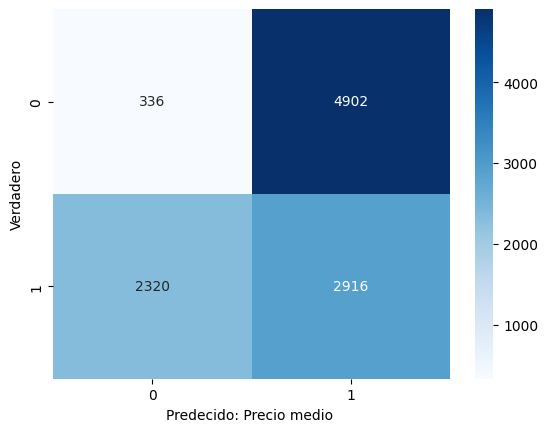

In [67]:
cm = confusion_matrix(y_test_medio,y_pred_medio)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predecido: Precio medio ')
plt.ylabel('Verdadero')

Text(50.722222222222214, 0.5, 'Verdadero')

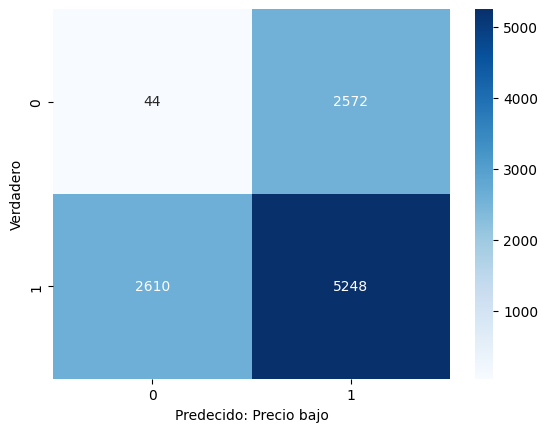

In [64]:
cm = confusion_matrix(y_test_bajo,y_pred_bajo)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predecido: Precio bajo')
plt.ylabel('Verdadero')

In [ ]:
ds_id3 = pd.get_dummies(ds.drop(columns=["property_price","pxm2"]),columns=["property_type","place_l3"])
ds_id3.info()
ds_id3.tipo_precio.value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52366 entries, 0 to 52365
Data columns (total 67 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   latitud                        52366 non-null  float64
 1   longitud                       52366 non-null  float64
 2   property_rooms                 52366 non-null  int64  
 3   property_bedrooms              52366 non-null  int64  
 4   property_surface_total         52366 non-null  float64
 5   property_surface_covered       52366 non-null  float64
 6   tipo_precio                    52366 non-null  object 
 7   property_type_Casa             52366 non-null  bool   
 8   property_type_Departamento     52366 non-null  bool   
 9   property_type_PH               52366 non-null  bool   
 10  place_l3_Abasto                52366 non-null  bool   
 11  place_l3_Agronomia             52366 non-null  bool   
 12  place_l3_Agronomía             52366 non-null 

tipo_precio
medio    0.500134
alto     0.250105
bajo     0.249761
Name: proportion, dtype: float64

In [ ]:
features= ds_id3.drop(columns=['tipo_precio']).columns.values
target='tipo_precio'

#ds_id3.info()
ds_id3[target] = ds_id3[target].map({'bajo':0,'medio':1,'alto':2},na_action=None)

X_train, X_test, Y_train, Y_test = train_test_split(ds_id3[features].values,
                                                    ds_id3[target].values,
                                                    test_size=0.2,    #20% al conjunto de test
                                                    random_state=13,  #para poder reproducir el experimento
                                                    stratify=ds_id3[target].values) #estratificado para mantener proporcion


In [ ]:
ds_id3[target].value_counts(normalize=True)*100
for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[Y_train,Y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

% Positivos Entrenamiento: 50.014
% Positivos Prueba: 50.010


In [ ]:
#Creo árbol con los mejores hiperparámetros
arbolcv=DecisionTreeClassifier()#.set_params(**randomcv.best_params_)

#Hago CV
resultados = cross_validate(arbolcv,X_train, Y_train, cv=StratifiedKFold(n_splits=5),scoring=make_scorer(f1_score),return_estimator=True)

metricsCV=resultados['test_score']
# mejor_performance=resultados['estimator'][np.where(metricsCV==max(metricsCV))[0][0]]
